In [2]:
# Basic imports
import pandas as pd
import numpy as np
import inflection

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Association and attribute manipulation
from dython.nominal import associations

# Encoding and scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

# Oversampling
from imblearn.over_sampling import ADASYN

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report, make_scorer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Feature selection
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# Model persistence
import joblib
import pickle

# Deep learning
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

# Explainable AI
import shap


In [2]:
data = pd.read_csv("telecom customer churn.csv")
data.head()

customerID  tenure PhoneService        Contract PaperlessBilling  \
0  7590-VHVEG       1           No  Month-to-month              Yes   
1  5575-GNVDE      34          Yes        One year               No   
2  3668-QPYBK       2          Yes  Month-to-month              Yes   
3  7795-CFOCW      45           No        One year               No   
4  9237-HQITU       2          Yes  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges Churn  gender  ...  \
0           Electronic check           29.85        29.85    No  Female  ...   
1               Mailed check           56.95       1889.5    No    Male  ...   
2               Mailed check           53.85       108.15   Yes    Male  ...   
3  Bank transfer (automatic)           42.30      1840.75    No    Male  ...   
4           Electronic check           70.70       151.65   Yes  Female  ...   

   Partner Dependents     MultipleLines InternetService OnlineSecurity  \
0      Yes         No  No phone service             DSL             No   
1       No         No                No             DSL            Yes   
2       No         No                No             DSL            Yes   
3       No         No  No phone service             DSL            Yes   
4       No         No                No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  
0          Yes               No          No          No              No  
1           No              Yes          No          No              No  
2          Yes               No          No          No              No  
3           No              Yes         Yes          No              No  
4           No               No          No          No              No  

[5 rows x 21 columns]

**I. EDA**

In [3]:
# renaming the column
column_list = list(data.columns)

for i, col in enumerate(column_list):
  column_list[i] = inflection.underscore(column_list[i]).replace(' ', '_')

data.columns = column_list
data.head()

customer_id  tenure phone_service        contract paperless_billing  \
0  7590-VHVEG       1            No  Month-to-month               Yes   
1  5575-GNVDE      34           Yes        One year                No   
2  3668-QPYBK       2           Yes  Month-to-month               Yes   
3  7795-CFOCW      45            No        One year                No   
4  9237-HQITU       2           Yes  Month-to-month               Yes   

              payment_method  monthly_charges total_charges churn  gender  \
0           Electronic check            29.85         29.85    No  Female   
1               Mailed check            56.95        1889.5    No    Male   
2               Mailed check            53.85        108.15   Yes    Male   
3  Bank transfer (automatic)            42.30       1840.75    No    Male   
4           Electronic check            70.70        151.65   Yes  Female   

   ...  partner dependents    multiple_lines internet_service online_security  \
0  ...      Yes         No  No phone service              DSL              No   
1  ...       No         No                No              DSL             Yes   
2  ...       No         No                No              DSL             Yes   
3  ...       No         No  No phone service              DSL             Yes   
4  ...       No         No                No      Fiber optic              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  
0           Yes                No           No           No               No  
1            No               Yes           No           No               No  
2           Yes                No           No           No               No  
3            No               Yes          Yes           No               No  
4            No                No           No           No               No  

[5 rows x 21 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   tenure             7043 non-null   int64  
 2   phone_service      7043 non-null   object 
 3   contract           7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   churn              7043 non-null   object 
 9   gender             7043 non-null   object 
 10  senior_citizen     7043 non-null   int64  
 11  partner            7043 non-null   object 
 12  dependents         7043 non-null   object 
 13  multiple_lines     7043 non-null   object 
 14  internet_service   7043 non-null   object 
 15  online_security    7043 non-null   object 
 16  online_backup      7043 

In [5]:
# Converting Total Charges to a numerical data type.
data.total_charges = pd.to_numeric(data.total_charges, errors='coerce')
data.isnull().sum()

customer_id           0
tenure                0
phone_service         0
contract              0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
churn                 0
gender                0
senior_citizen        0
partner               0
dependents            0
multiple_lines        0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
dtype: int64

After looking at the above output, we can say that there are 11 missing values for Total Charges. Let us replace remove these 11 rows from our data set

In [6]:
# Removing missing values
data.dropna(inplace=True)

# Remove customer IDs from the data set
df2 = data.iloc[:, 1:]

# Converting the predictor variable to a binary numeric variable
df2['churn'] = df2['churn'].map({'Yes': 1, 'No': 0})

# Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()


tenure  monthly_charges  total_charges  churn  senior_citizen  \
0       1            29.85          29.85      0               0   
1      34            56.95        1889.50      0               0   
2       2            53.85         108.15      1               0   
3      45            42.30        1840.75      0               0   
4       2            70.70         151.65      1               0   

   phone_service_No  phone_service_Yes  contract_Month-to-month  \
0              True              False                     True   
1             False               True                    False   
2             False               True                     True   
3              True              False                    False   
4             False               True                     True   

   contract_One year  contract_Two year  ...  device_protection_Yes  \
0              False              False  ...                  False   
1               True              False  ...                   True   
2              False              False  ...                  False   
3               True              False  ...                   True   
4              False              False  ...                  False   

   tech_support_No  tech_support_No internet service  tech_support_Yes  \
0             True                             False             False   
1             True                             False             False   
2             True                             False             False   
3            False                             False              True   
4             True                             False             False   

   streaming_tv_No  streaming_tv_No internet service  streaming_tv_Yes  \
0             True                             False             False   
1             True                             False             False   
2             True                             False             False   
3             True                             False             False   
4             True                             False             False   

   streaming_movies_No  streaming_movies_No internet service  \
0                 True                                 False   
1                 True                                 False   
2                 True                                 False   
3                 True                                 False   
4                 True                                 False   

   streaming_movies_Yes  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  

[5 rows x 46 columns]

In [7]:
df2.info()
df2.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tenure             7032 non-null   int64  
 1   phone_service      7032 non-null   object 
 2   contract           7032 non-null   object 
 3   paperless_billing  7032 non-null   object 
 4   payment_method     7032 non-null   object 
 5   monthly_charges    7032 non-null   float64
 6   total_charges      7032 non-null   float64
 7   churn              7032 non-null   int64  
 8   gender             7032 non-null   object 
 9   senior_citizen     7032 non-null   int64  
 10  partner            7032 non-null   object 
 11  dependents         7032 non-null   object 
 12  multiple_lines     7032 non-null   object 
 13  internet_service   7032 non-null   object 
 14  online_security    7032 non-null   object 
 15  online_backup      7032 non-null   object 
 16  device_protection  7032 non-n

tenure  monthly_charges  total_charges        churn  \
count  7032.000000      7032.000000    7032.000000  7032.000000   
mean     32.421786        64.798208    2283.300441     0.265785   
std      24.545260        30.085974    2266.771362     0.441782   
min       1.000000        18.250000      18.800000     0.000000   
25%       9.000000        35.587500     401.450000     0.000000   
50%      29.000000        70.350000    1397.475000     0.000000   
75%      55.000000        89.862500    3794.737500     1.000000   
max      72.000000       118.750000    8684.800000     1.000000   

       senior_citizen  
count     7032.000000  
mean         0.162400  
std          0.368844  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000

<Axes: >

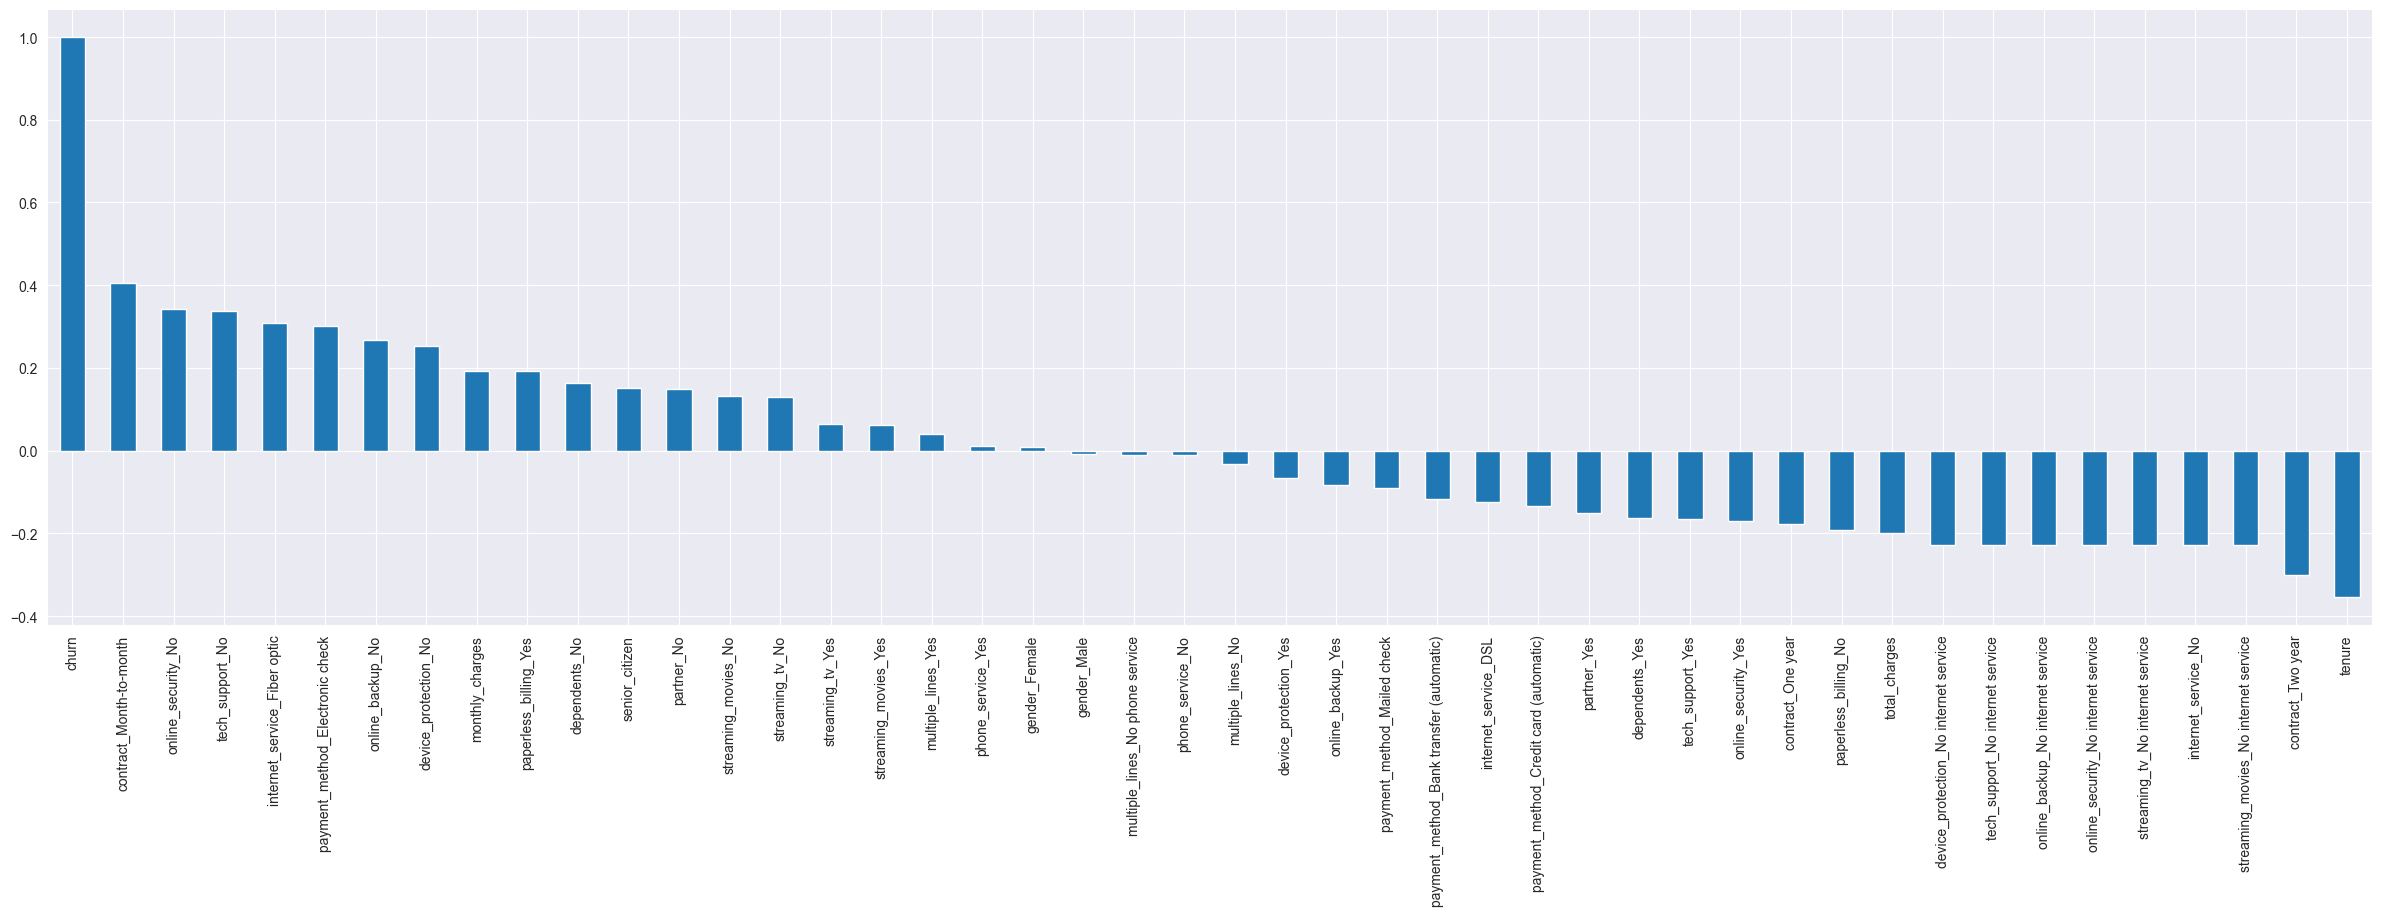

In [8]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(30,8))
df_dummies.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

Month to month contracts, absence of online security and tech support seem to be positively correlated with churn. While, tenure, two year contracts seem to be negatively correlated with churn.

Interestingly, services such as Online security, streaming TV, online backup, tech support, etc. without internet connection seem to be negatively related to churn.

We will explore the patterns for the above correlations below before we delve into modelling and identifying the important variables.

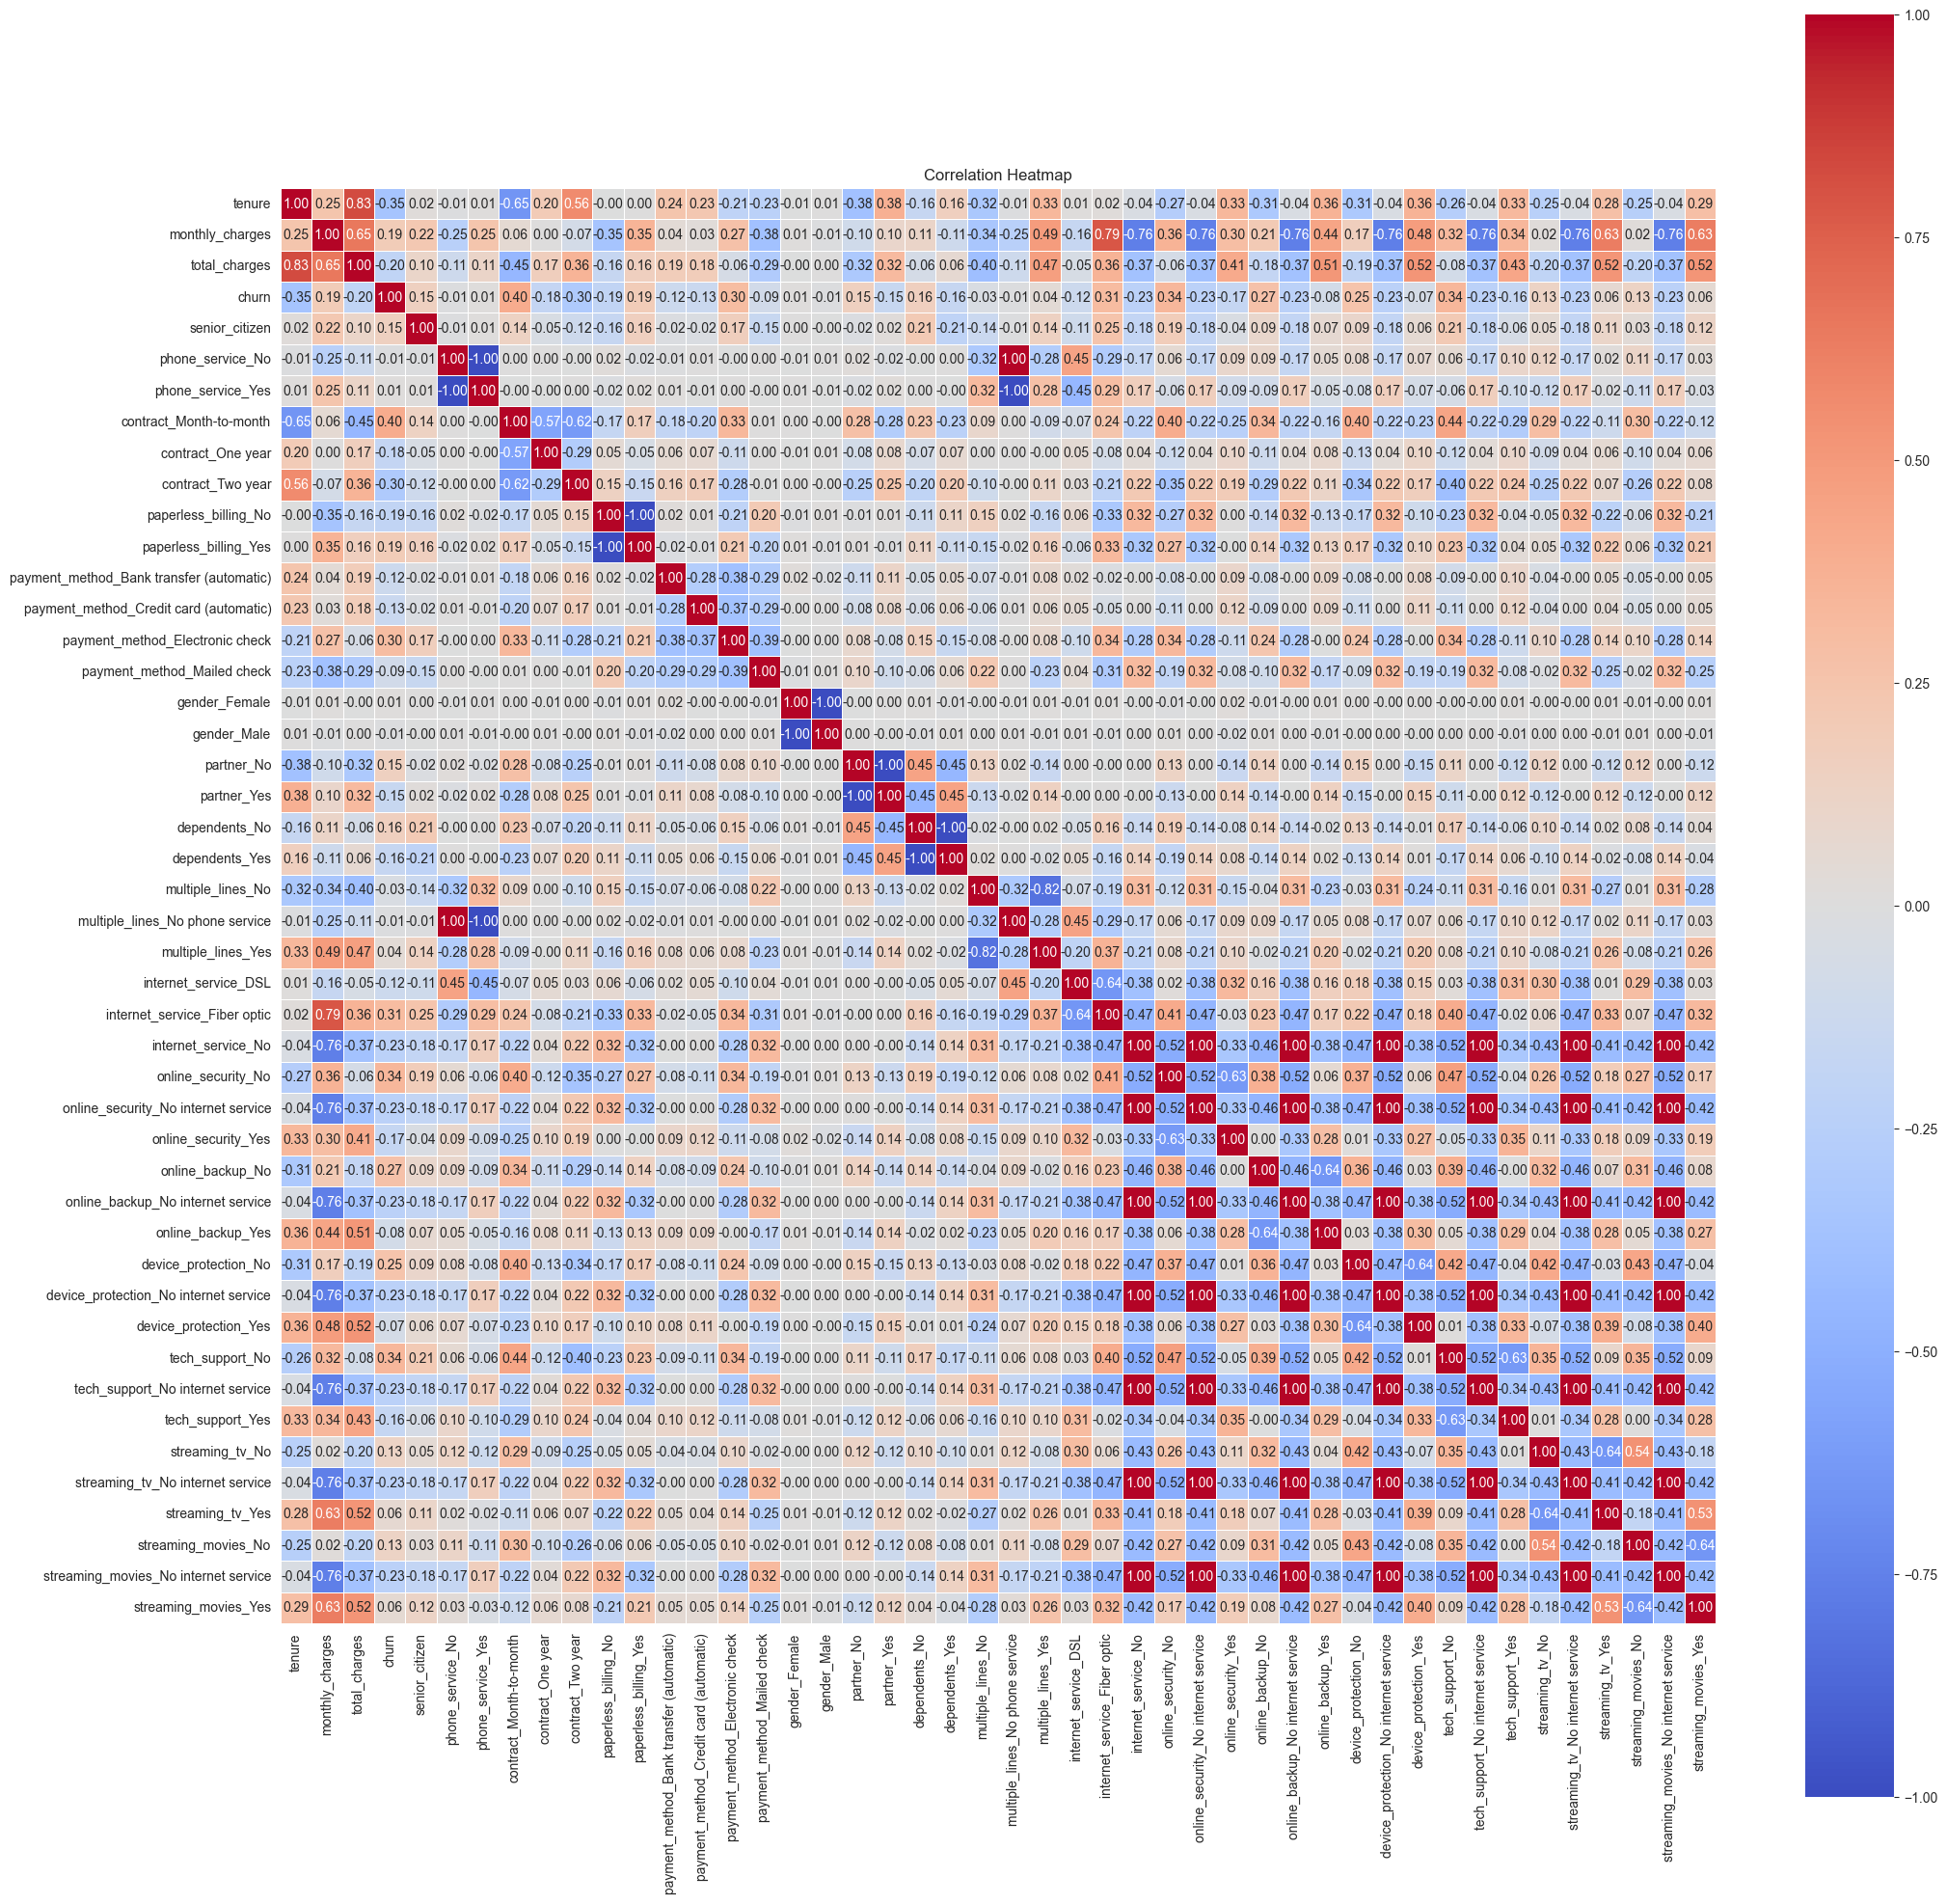

In [9]:
# Tính ma trận tương quan
correlation_matrix = df_dummies.corr()

# Tạo heatmap
plt.figure(figsize=(24, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 10}, square=True)
plt.title('Correlation Heatmap')
plt.xticks(fontsize=10) # Điều chỉnh kích thước font cho các nhãn trục x
plt.yticks(fontsize=10) # Điều chỉnh kích thước font cho các nhãn trục y
plt.show()

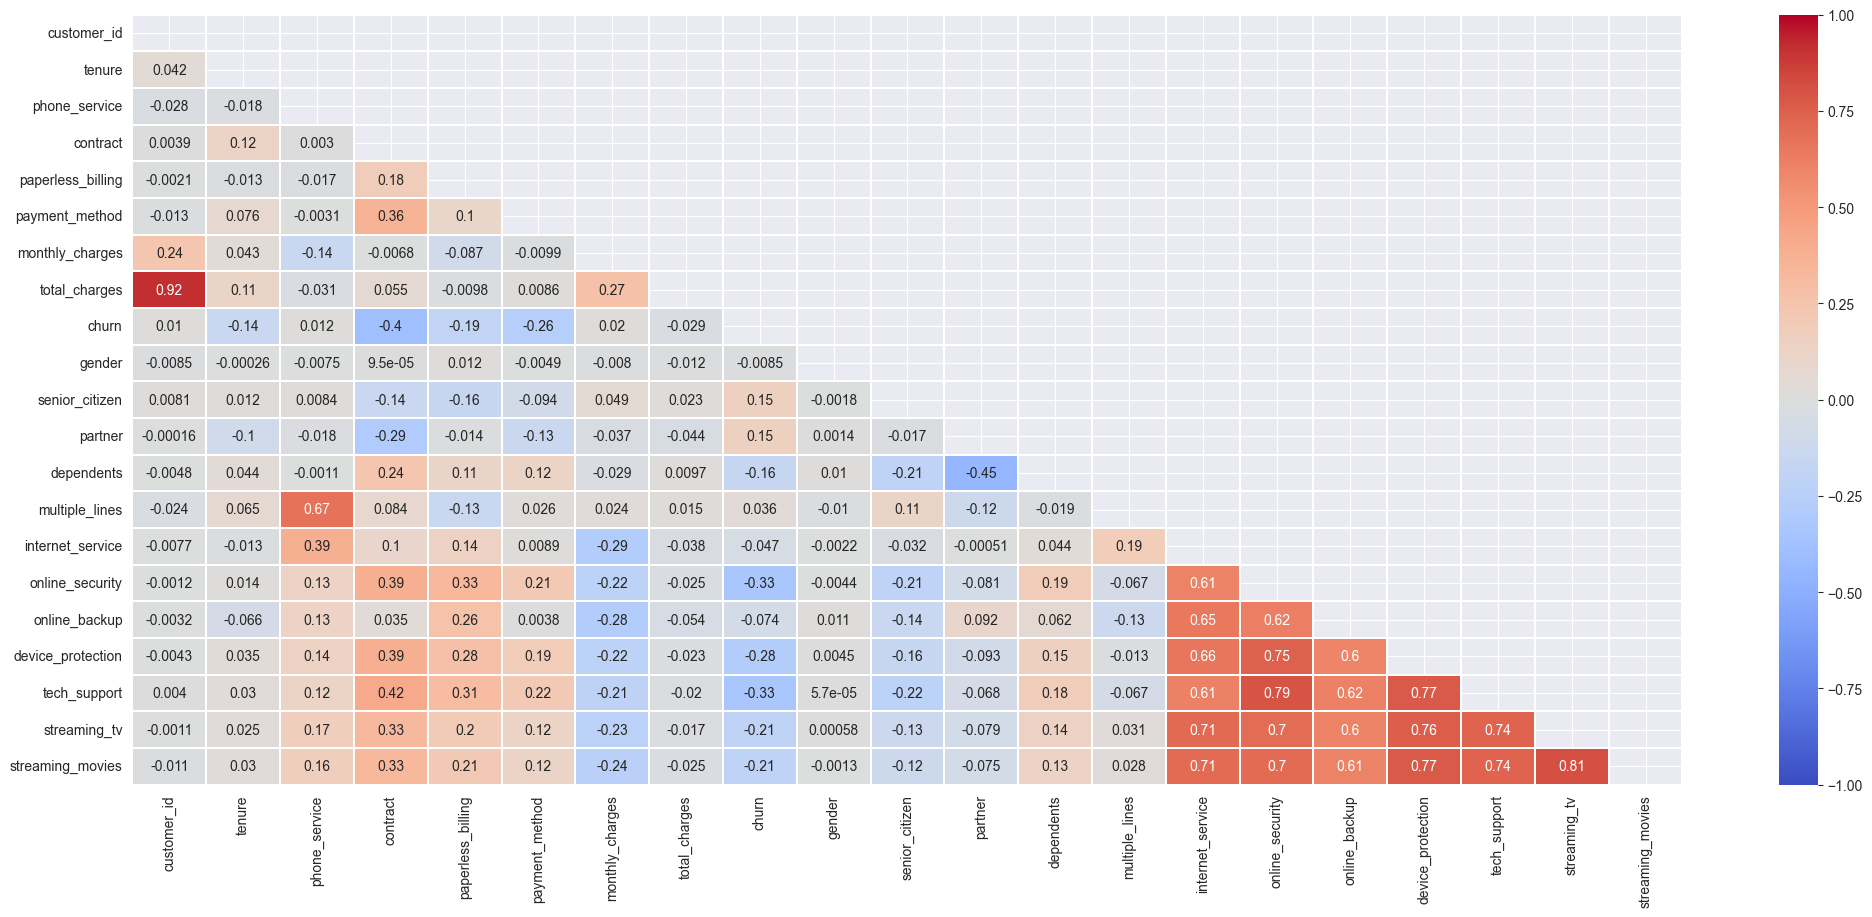

In [10]:
plt.figure(figsize=(25, 10))

corr = data.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

**A.) Demographics** - Let us first understand the gender, patner and dependent status of the customers

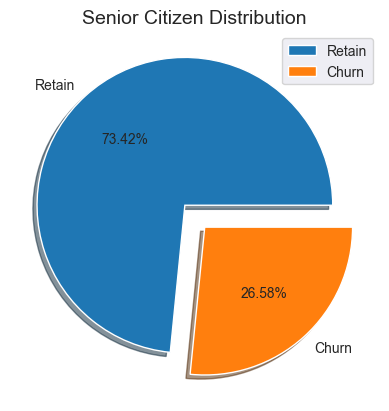

In [11]:
plt.pie(
    data['churn'].value_counts(),
    labels=['Retain', 'Churn'],
    autopct='%.2f%%',
    shadow=True,
    explode=[0.1, 0.1]
);
plt.title('Senior Citizen Distribution', fontsize=14)
plt.legend();

As we can see, 26.58% of customers leave the services. Technically speaking, this dataset is an imbalanced dataset.

**1. Gender Distribution** - About half of the customers in our data set are male while the other half are female

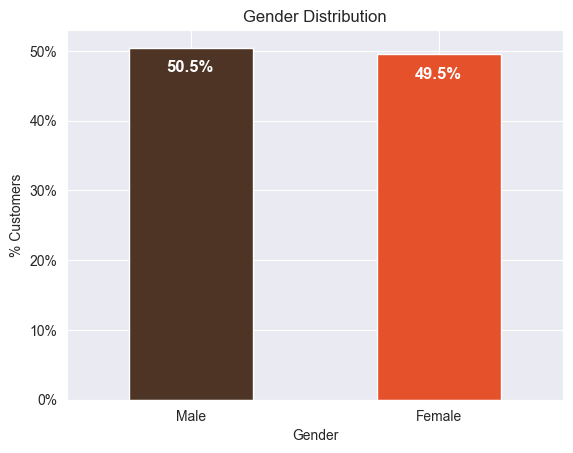

In [12]:
import matplotlib.ticker as mtick

colors = ['#4D3425','#E4512B']
ax = (data['gender'].value_counts()*100.0 /len(data)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')

In [13]:
import plotly.express as px

fig = px.histogram(data, x="churn", color="contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

About 75% of customer with Month-to-Month Contract opted to move out as compared to 13% of customrs with One Year Contract and 3% with Two Year Contract

In [14]:
import plotly.graph_objects as go

labels = data['payment_method'].unique()
values = data['payment_method'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

In [15]:
fig = px.histogram(data, x="churn", color="payment_method", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

- Major customers who moved out were having Electronic Check as Payment Method.
- Customers who opted for Credit-Card automatic transfer or Bank Automatic Transfer and Mailed Check as Payment Method were less likely to move out.

**2. Senior Citizens** - There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.

Text(0.5, 1.0, '% of Senior Citizens')

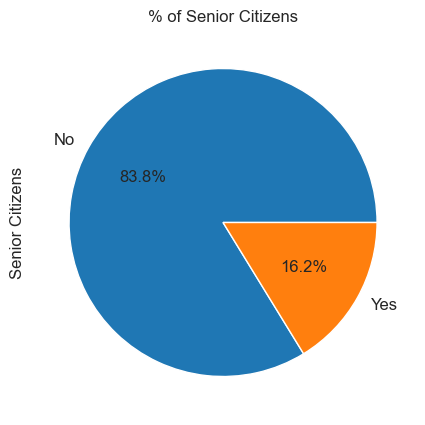

In [16]:
ax = (data['senior_citizen'].value_counts()*100.0 /len(data))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

In [17]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(data, x="churn", color="senior_citizen", title="<b>Chrun distribution w.r.t. Senior Citizen</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

- It can be observed that the fraction of senior citizen is very less.
- Most of the senior citizens churn.

In [18]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(data, x="churn", color="online_security", barmode="group", title="<b>Churn w.r.t Online Security</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

- Most customers churn in the absence of online security

In [19]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(data, x="churn", color="paperless_billing",  title="<b>Chrun distribution w.r.t. Paperless Billing</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

- Customers with Paperless Billing are most likely to churn.

In [20]:
fig = px.histogram(data, x="churn", color="tech_support",barmode="group",  title="<b>Chrun distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

- Customers with no TechSupport are most likely to migrate to another service provider.

In [21]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(data, x="churn", color="phone_service", title="<b>Chrun distribution w.r.t. Phone Service</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

- Very small fraction of customers don't have a phone service and out of that, 1/3rd Customers are more likely to churn.


In [22]:
data.columns.values

array(['customer_id', 'tenure', 'phone_service', 'contract',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'churn', 'gender', 'senior_citizen', 'partner',
       'dependents', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies'], dtype=object)

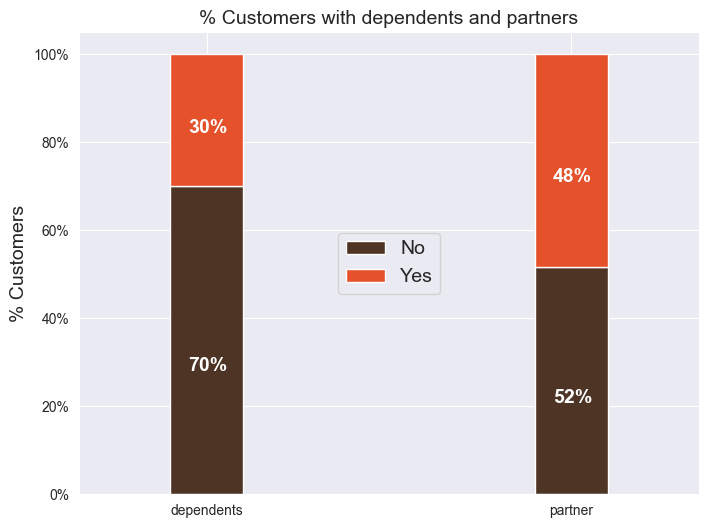

In [23]:
df2 = pd.melt(data, id_vars=['customer_id'], value_vars=['dependents','partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(data)
colors = ['#4D3425','#E4512B']
ax = df3.loc[:,'customer_id'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

What would be interesting is to look at the % of customers, who have partners, also have dependents. We will explore this next.

Interestingly, among the customers who have a partner, only about half of them also have a dependent, while other half do not have any independents. Additionally, as expected, among the customers who do not have any partner, a majority (80%) of them do not have any dependents .

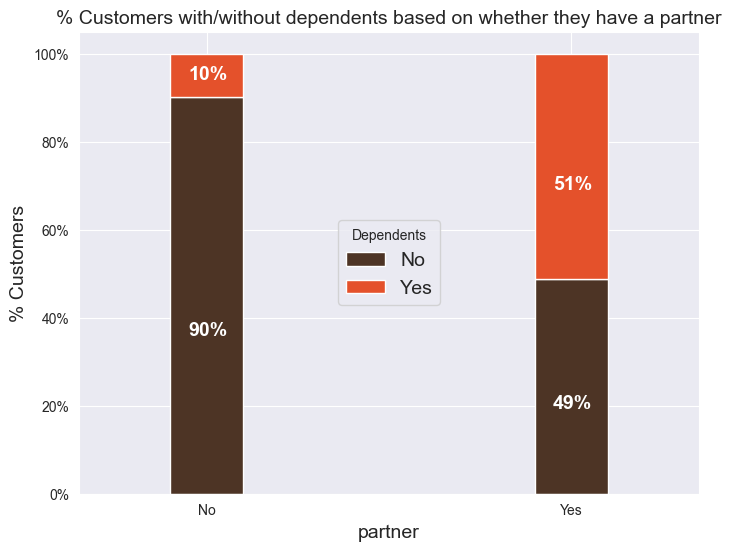

In [24]:
colors = ['#4D3425','#E4512B']
partner_dependents =data.groupby(['partner','dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

We also looked at any differences between the % of customers with/without dependents and partners by gender. There is no difference in their distribution by gender. Additionally, there is no difference in senior citizen status by gender.

In [25]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(data, x="churn", color="dependents", barmode="group", title="<b>Dependents distribution</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

- Customers without dependents are more likely to churn

In [26]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(data, x="churn", color="partner", barmode="group", title="<b>Chrun distribution w.r.t. Partners</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

- Customers that doesn't have partners are more likely to churn

**B.) Customer Account Information:** Let u now look at the tenure, contract

**1. Tenure:** After looking at the below histogram we can see that a lot of customers have been with the telecom company for just a month, while quite a many are there for about 72 months. This could be potentially because different customers have different contracts. Thus based on the contract they are into it could be more/less easier for the customers to stay/leave the telecom company.

Text(0.5, 1.0, '# of Customers by their tenure')

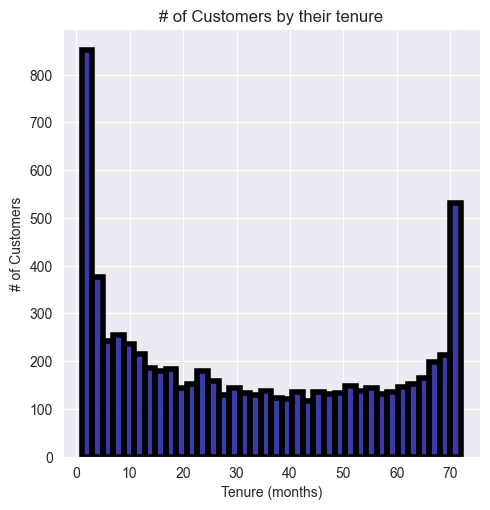

In [27]:
# Vẽ biểu đồ
sns.displot(data['tenure'], kind='hist', bins=int(180/5), color='darkblue', edgecolor='black', linewidth=4)

# Đặt nhãn và tiêu đề cho biểu đồ
plt.ylabel('# of Customers')
plt.xlabel('Tenure (months)')
plt.title('# of Customers by their tenure')

**2. Contracts:** To understand the above graph, lets first look at the # of customers by different contracts.

Text(0.5, 1.0, '# of Customers by Contract Type')

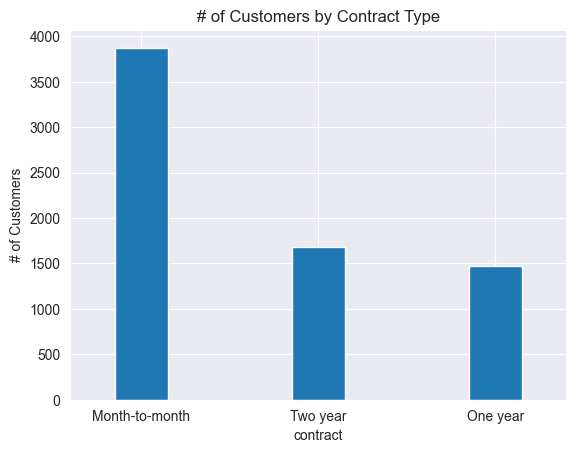

In [28]:
ax = data['contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

As we can see from this graph most of the customers are in the month to month contract. While there are equal number of customers in the 1 year and 2 year contracts.

Below we will understand the tenure of customers based on their contract type.

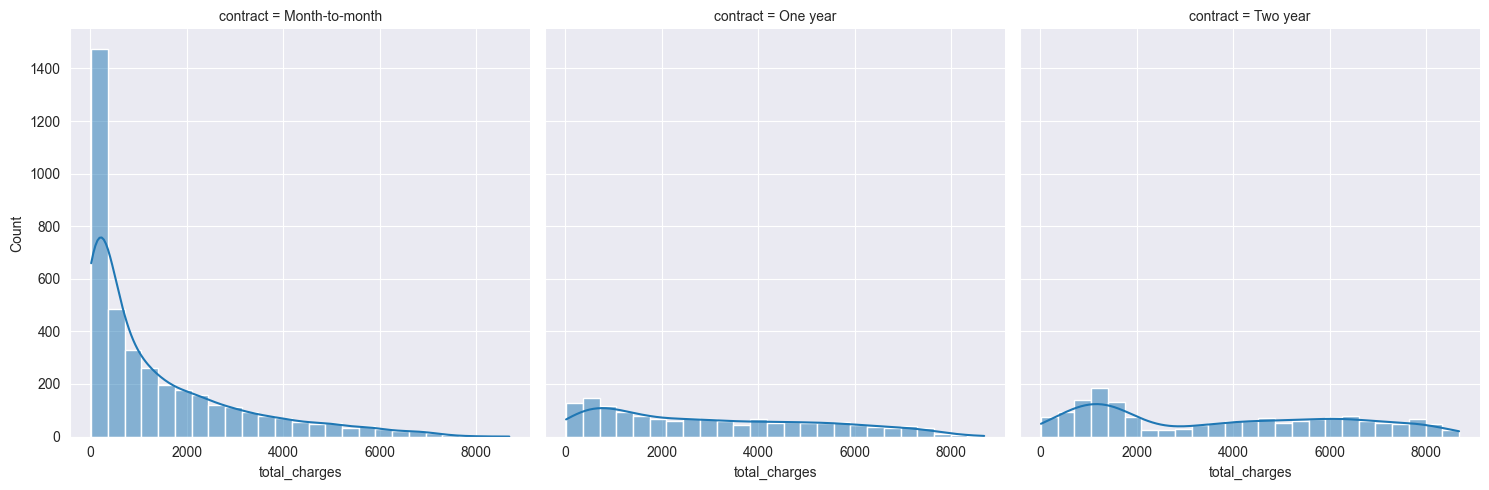

In [29]:
sns.displot(data=data,x='total_charges',col='contract',kde=True);

Interestingly most of the monthly contracts last for 1-2 months, while the 2 year contracts tend to last for about 70 months. This shows that the customers taking a longer contract are more loyal to the company and tend to stay with it for a longer period of time.

This is also what we saw in the earlier chart on correlation with the churn rate.

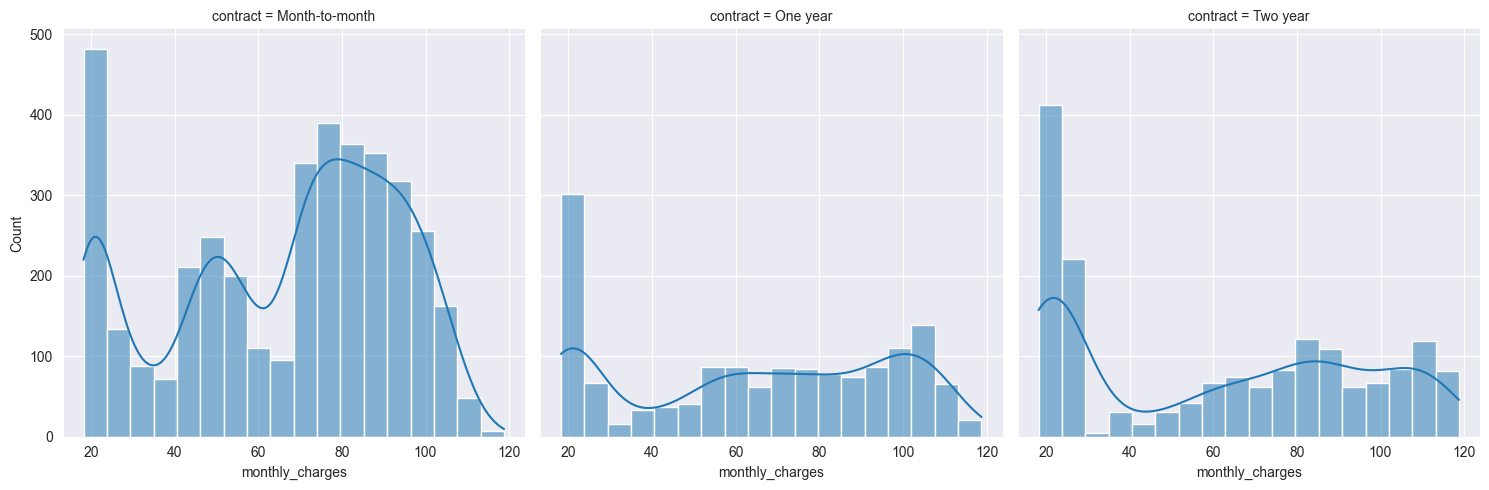

In [30]:
sns.displot(data=data,x='monthly_charges',col='contract',kde=True);

Since the numerical features are distributed over different value ranges, I will use standard scalar to scale them down to the same range.

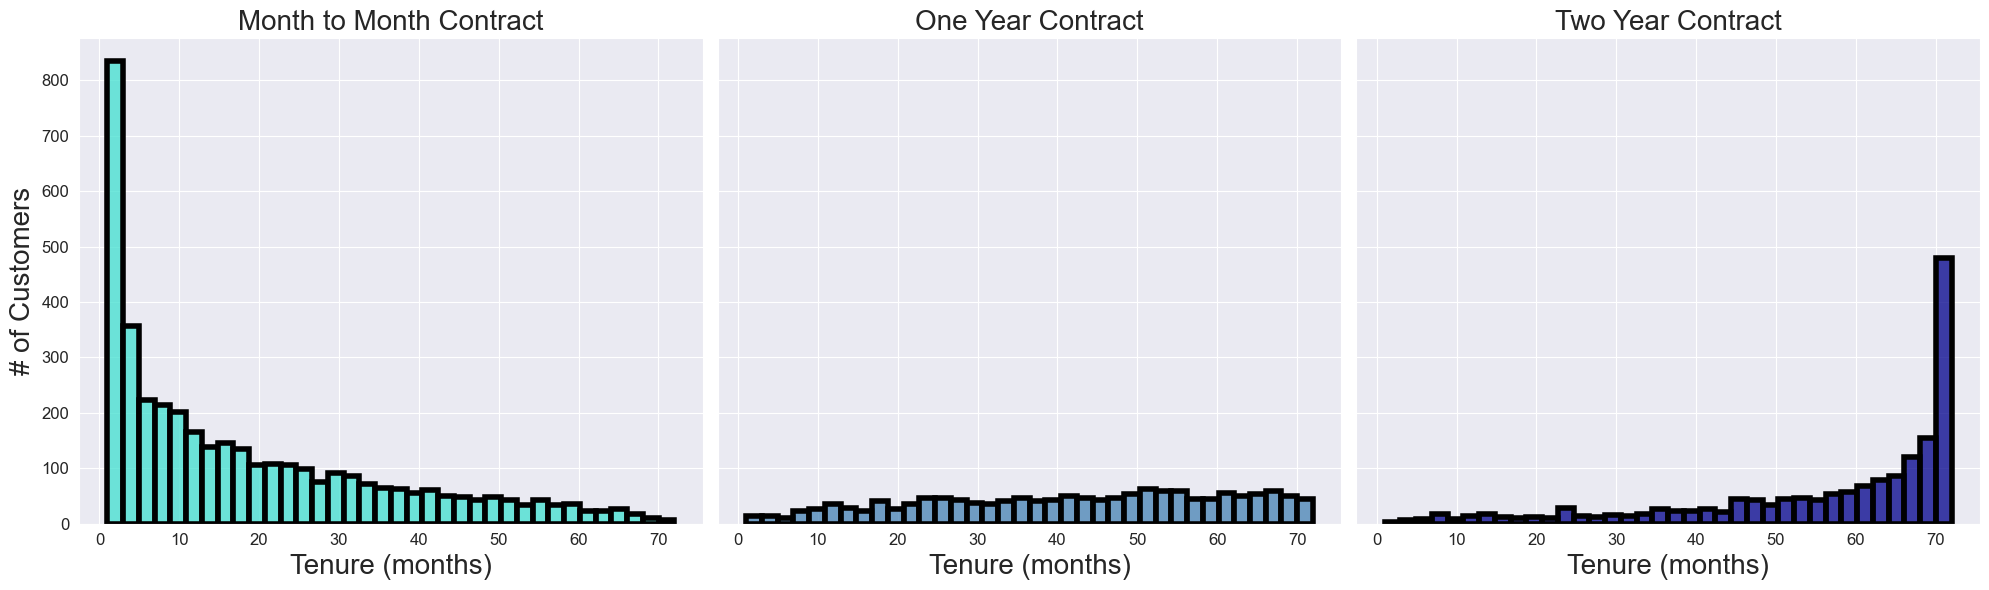

In [31]:
# Tạo figure và các axes
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 6))

# Biểu đồ Month to Month Contract
sns.histplot(data=data[data['contract']=='Month-to-month'], 
             x='tenure', kde=False, bins=int(180/5), color='turquoise', 
             edgecolor='black', linewidth=4, ax=ax1)

ax1.set_ylabel('# of Customers', fontsize=20)
ax1.set_xlabel('Tenure (months)', fontsize=20)
ax1.set_title('Month to Month Contract', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Biểu đồ One Year Contract
sns.histplot(data=data[data['contract']=='One year'], 
             x='tenure', kde=False, bins=int(180/5), color='steelblue', 
             edgecolor='black', linewidth=4, ax=ax2)

ax2.set_ylabel('# of Customers', fontsize=20)
ax2.set_xlabel('Tenure (months)', fontsize=20)
ax2.set_title('One Year Contract', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Biểu đồ Two Year Contract
sns.histplot(data=data[data['contract']=='Two year'], 
             x='tenure', kde=False, bins=int(180/5), color='darkblue', 
             edgecolor='black', linewidth=4, ax=ax3)

ax3.set_ylabel('# of Customers', fontsize=20)
ax3.set_xlabel('Tenure (months)', fontsize=20)
ax3.set_title('Two Year Contract', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=12)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

**C. Let us now look at the distribution of various services used by customers**

In [32]:
data.columns.values

array(['customer_id', 'tenure', 'phone_service', 'contract',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'churn', 'gender', 'senior_citizen', 'partner',
       'dependents', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies'], dtype=object)

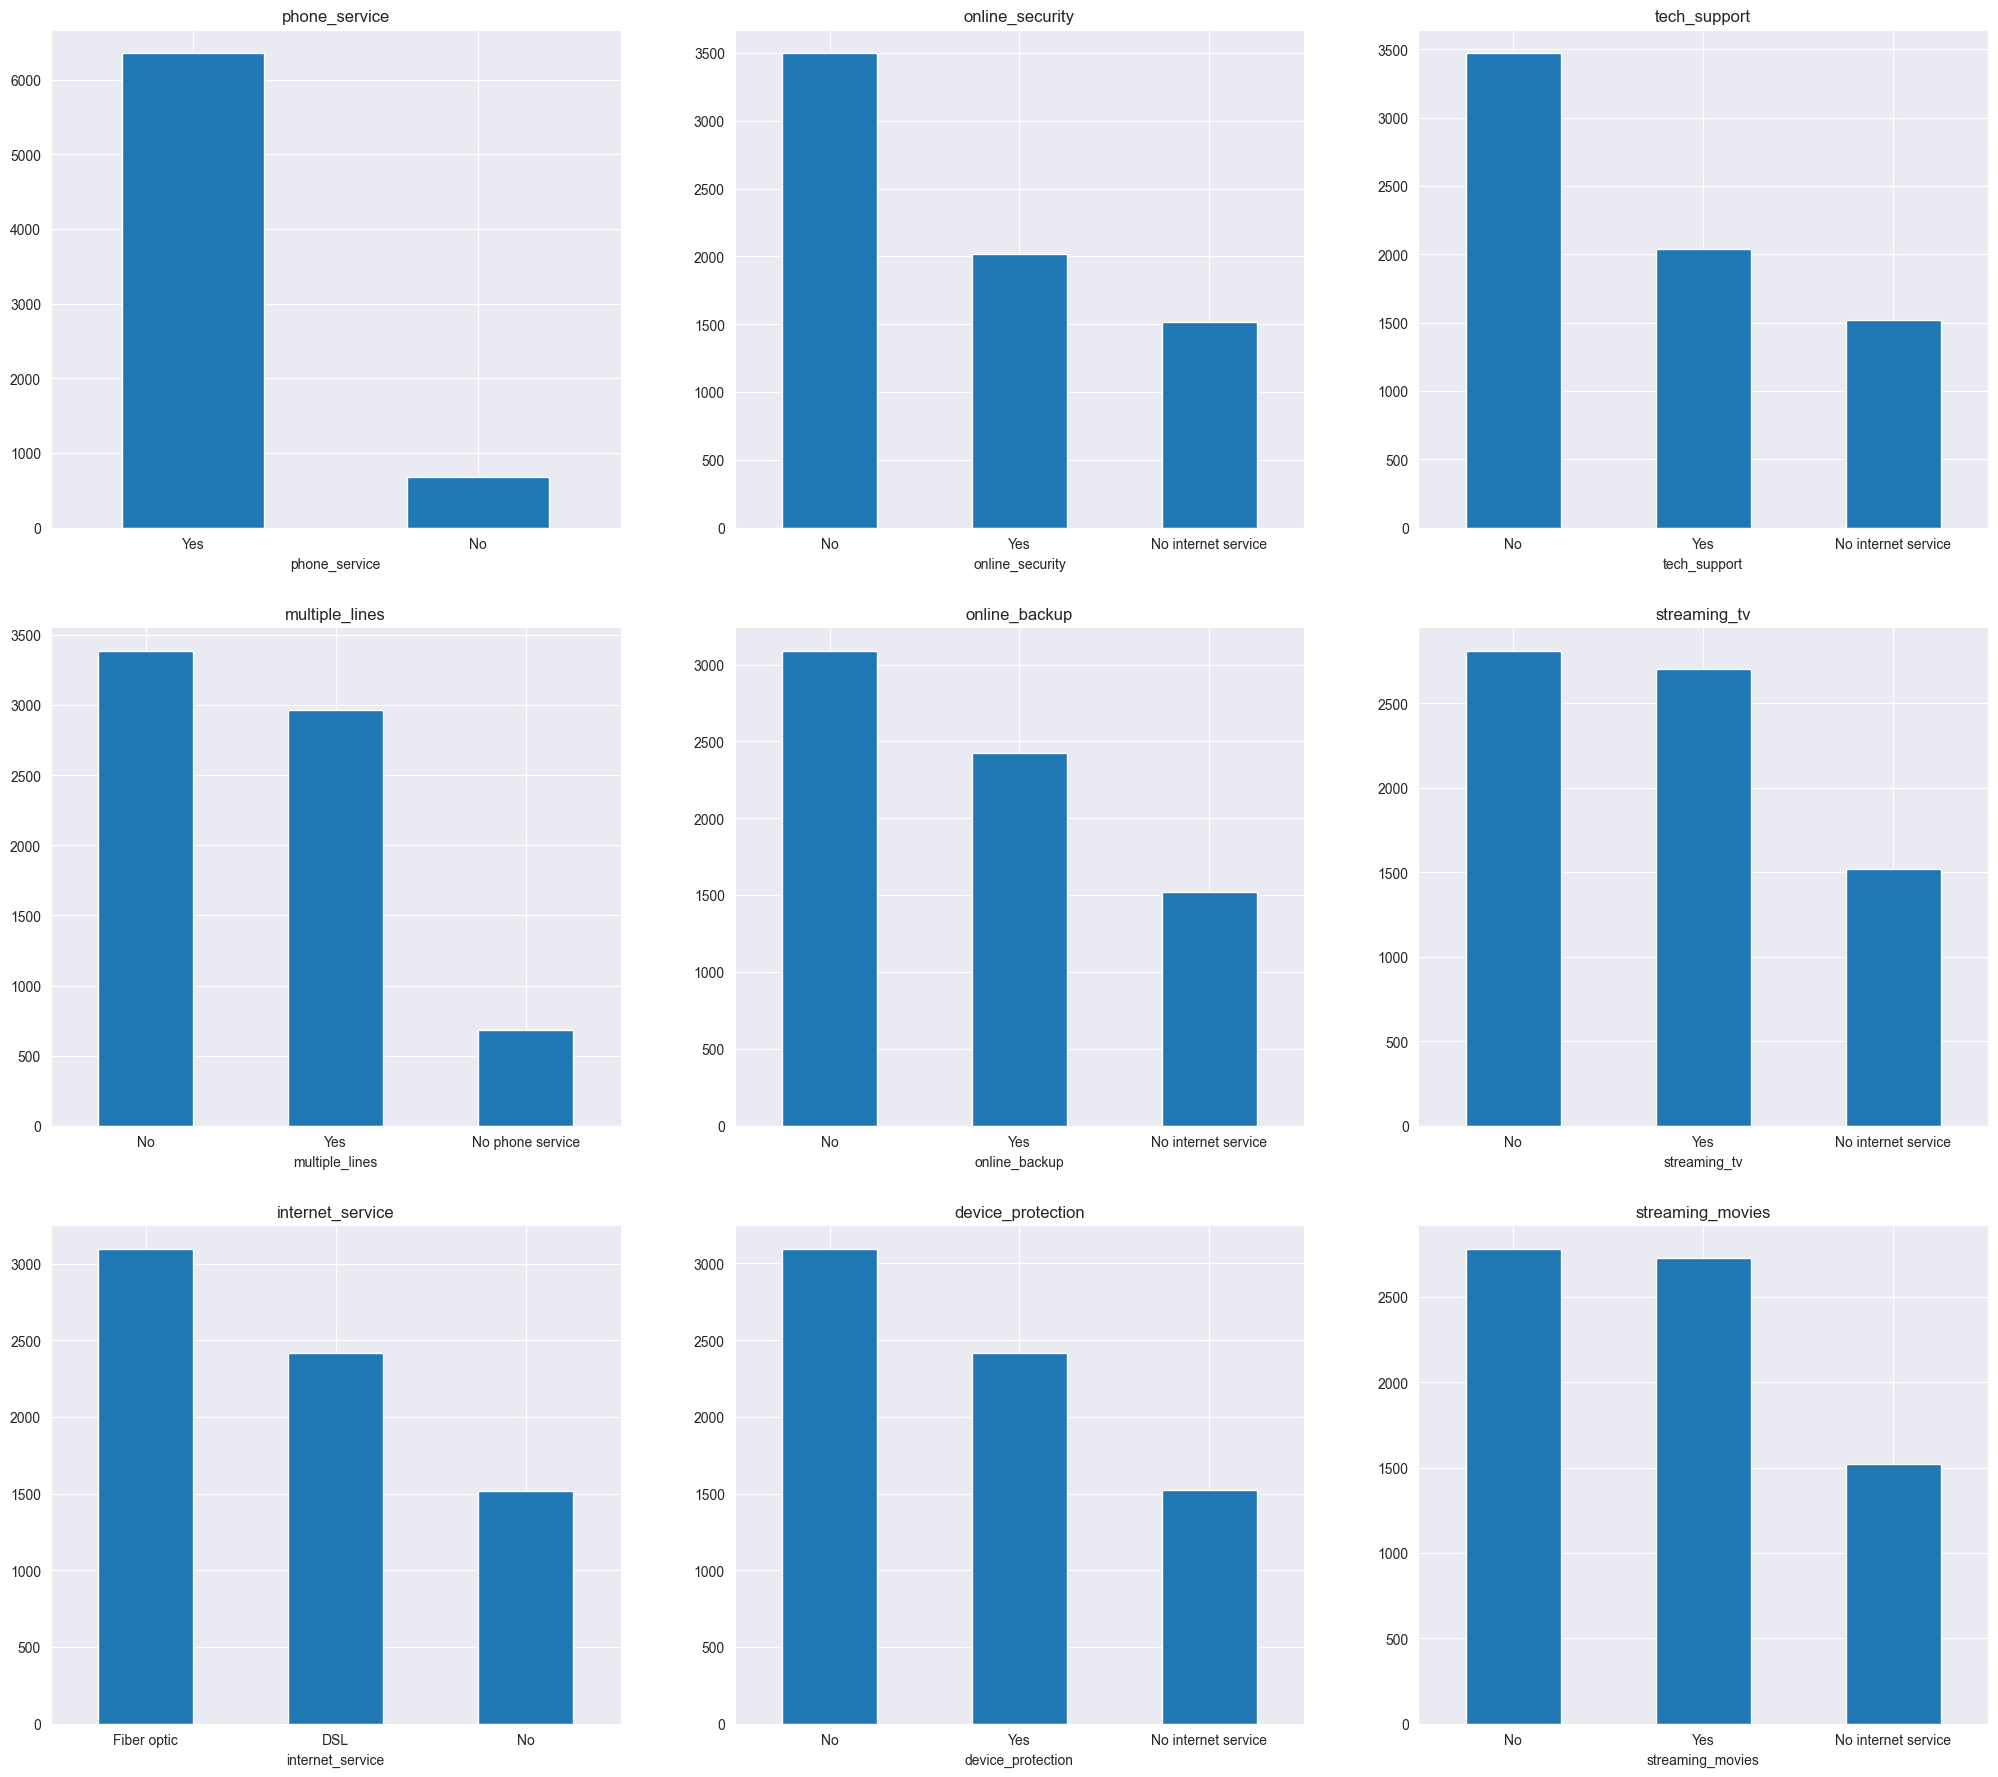

In [33]:
services = ['phone_service','multiple_lines','internet_service','online_security',
           'online_backup','device_protection','tech_support','streaming_tv','streaming_movies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (25,22))
for i, item in enumerate(services):
    if i < 3:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)


**D.) Now let's take a quick look at the relation between monthly and total charges**

<Axes: xlabel='monthly_charges', ylabel='total_charges'>

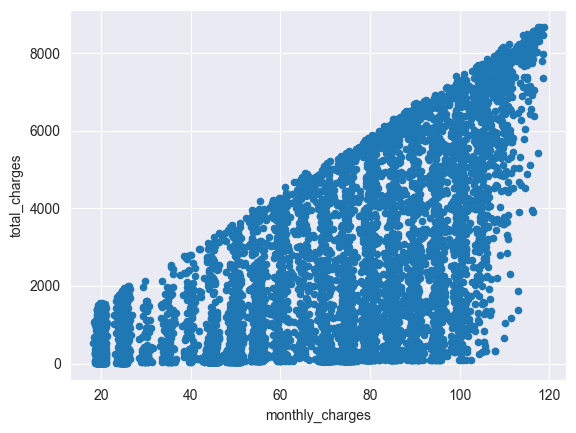

In [34]:
data[['monthly_charges', 'total_charges']].plot.scatter(x = 'monthly_charges',
                                                              y='total_charges')

**E.) Finally, let's take a look at out predictor variable (Churn) and understand its interaction with other important variables as was found out in the correlation plot.**

**1.Lets first look at the churn rate in our data**

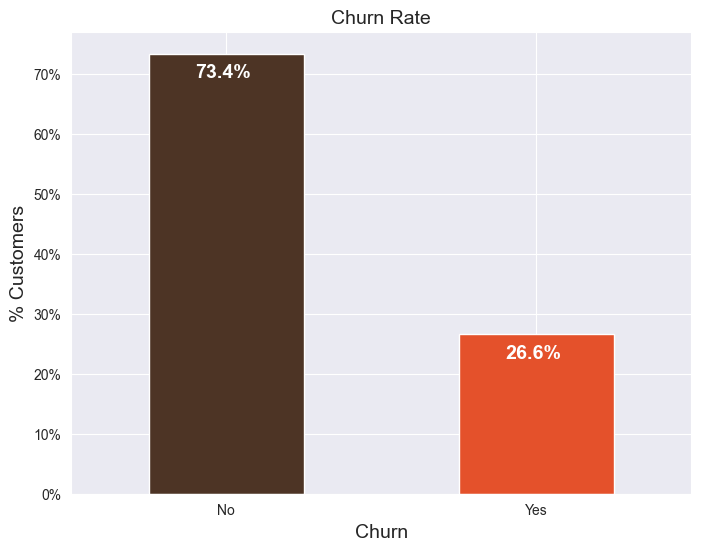

In [35]:
colors = ['#4D3425','#E4512B']
ax = (data['churn'].value_counts()*100.0 /len(data)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            color='white',
           weight = 'bold',
           size = 14)

In our data, 74% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

**2. Lets now explore the churn rate by tenure, seniority, contract type, monthly charges and total charges to see how it varies by these variables.**

**i.) Churn vs Tenure:** As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company.

<Axes: xlabel='churn', ylabel='tenure'>

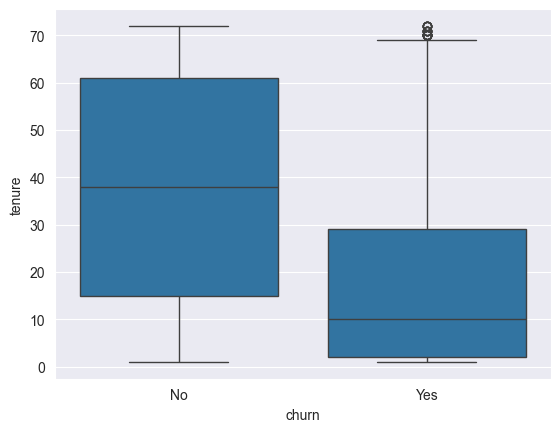

In [36]:
sns.boxplot(x = data.churn, y = data.tenure)

**ii.) Churn by Contract Type:** Similar to what we saw in the correlation plot, the customers who have a month to month contract have a very high churn rate.

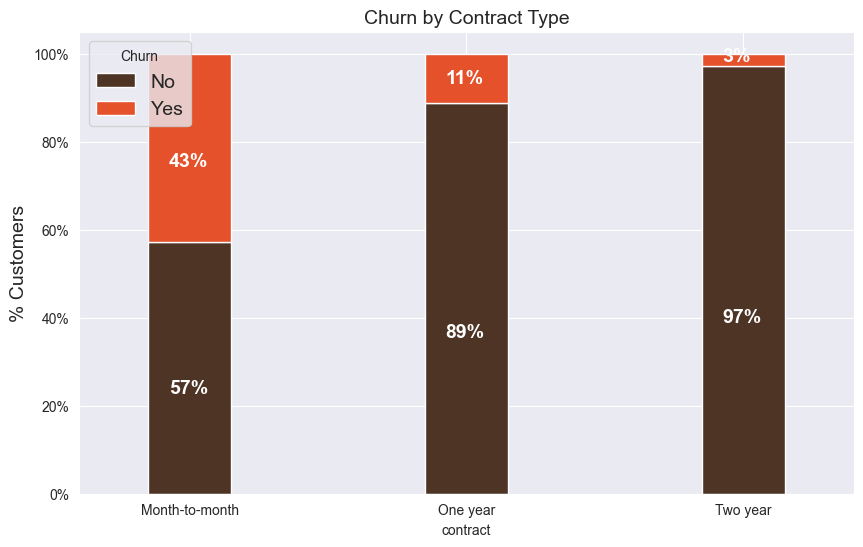

In [37]:
colors = ['#4D3425','#E4512B']
contract_churn = data.groupby(['contract','churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

**iii.) Churn by Seniority:** Senior Citizens have almost double the churn rate than younger population.

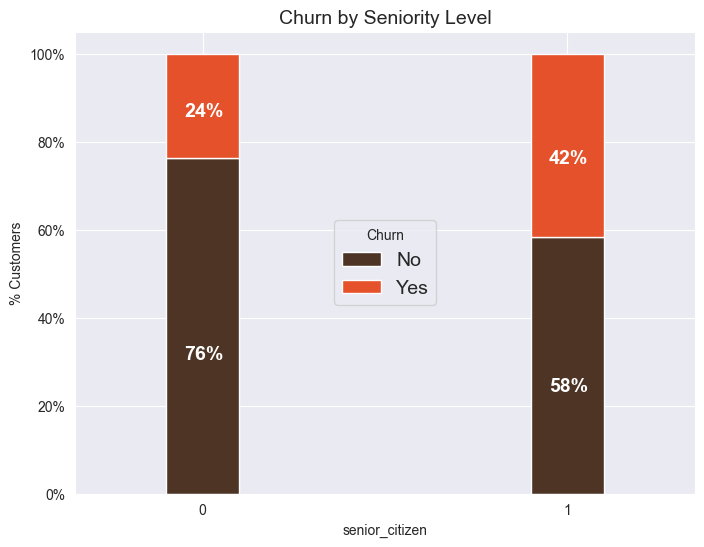

In [38]:
colors = ['#4D3425','#E4512B']
seniority_churn = data.groupby(['senior_citizen','churn']).size().unstack()

ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

**iv.) Churn by Monthly Charges:** Higher % of customers churn when the monthly charges are high.

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

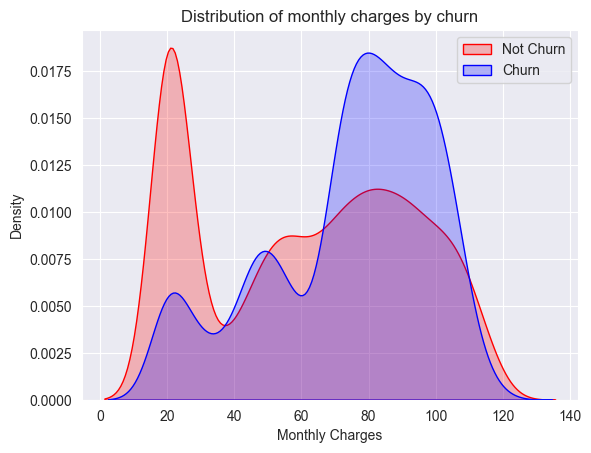

In [39]:
ax = sns.kdeplot(data.monthly_charges[(data["churn"] == 'No') ],
                color="Red", fill = True)
ax = sns.kdeplot(data.monthly_charges[(data["churn"] == 'Yes') ],
                ax =ax, color="Blue", fill = True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

**v.) Churn by Total Charges:** It seems that there is higer churn when the total charges are lower.

Text(0.5, 1.0, 'Distribution of total charges by churn')

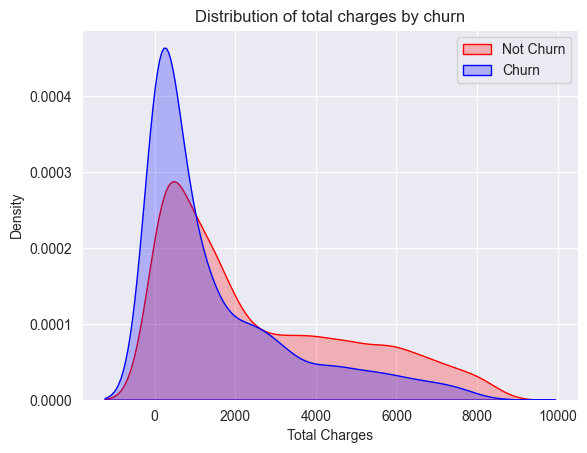

In [40]:
ax = sns.kdeplot(data.total_charges[(data["churn"] == 'No') ],
                color="Red", fill = True)
ax = sns.kdeplot(data.total_charges[(data["churn"] == 'Yes') ],
                ax =ax, color="Blue", fill = True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

**II. Xử lý tập dữ liệu**

**1. Encode Target variable**

In [42]:
data_cleaned = data.copy()
data_cleaned.churn[data_cleaned.churn.str.lower() == 'yes'] = 1
data_cleaned.churn[data_cleaned.churn.str.lower() == 'no'] = 0

data_cleaned['churn'] = data_cleaned['churn'].astype('int')


C:\Users\assus\AppData\Local\Temp\ipykernel_12856\2412915541.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\assus\AppData\Local\Temp\ipykernel_12856\2412915541.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
# Xóa cột customer_id
data_cleaned2 = data_cleaned.iloc[:, 1:]

**2. One Hot Encoding**

In [48]:
# Xác định các cột biến phân loại
categorical_columns = data_cleaned2.select_dtypes(include=['object']).columns

# Loại bỏ các cột không phải biến phân loại
non_categorical_columns = ['tenure', 'monthly_charges', 'total_charges', 'churn', 'senior_citizen']
categorical_columns = [col for col in categorical_columns if col not in non_categorical_columns]

# Xóa dữ liệu các dòng có giá trị missing trong cột 'total_charges'
data_cleaned2 = data_cleaned2.dropna(subset=['total_charges'])

# Reset index
data_cleaned2 = data_cleaned2.reset_index(drop=True)

# Tạo DataFrame mới để lưu trữ dữ liệu sau khi mã hóa
df_encoded = pd.DataFrame()

# Mã hóa các biến phân loại thành dạng 0 và 1 sử dụng pd.get_dummies()
for column in categorical_columns:
    df_encoded = pd.concat([df_encoded, pd.get_dummies(data_cleaned2[column], prefix=column)], axis=1)

# Loại bỏ các cột biến phân loại gốc từ DataFrame
data_cleaned2.drop(columns=categorical_columns, inplace=True)

# Kết hợp DataFrame mới với dữ liệu đã mã hóa
data_cleaned_encoded = pd.concat([data_cleaned2, df_encoded], axis=1)

# Chuyển đổi giá trị True và False thành 1 và 0
data_cleaned_encoded = data_cleaned_encoded.astype(int)

# Lưu DataFrame đã được mã hóa thành file CSV
data_cleaned_encoded.to_csv('telco_churn_data_cleaned_encoded.csv', index=False)


In [50]:
data_cleaned_encoded

tenure  monthly_charges  total_charges  churn  senior_citizen  \
0          1               29             29      0               0   
1         34               56           1889      0               0   
2          2               53            108      1               0   
3         45               42           1840      0               0   
4          2               70            151      1               0   
...      ...              ...            ...    ...             ...   
7027      24               84           1990      0               0   
7028      72              103           7362      0               0   
7029      11               29            346      0               0   
7030       4               74            306      1               1   
7031      66              105           6844      0               0   

      phone_service_No  phone_service_Yes  contract_Month-to-month  \
0                    1                  0                        1   
1                    0                  1                        0   
2                    0                  1                        1   
3                    1                  0                        0   
4                    0                  1                        1   
...                ...                ...                      ...   
7027                 0                  1                        0   
7028                 0                  1                        0   
7029                 1                  0                        1   
7030                 0                  1                        1   
7031                 0                  1                        0   

      contract_One year  contract_Two year  ...  device_protection_Yes  \
0                     0                  0  ...                      0   
1                     1                  0  ...                      1   
2                     0                  0  ...                      0   
3                     1                  0  ...                      1   
4                     0                  0  ...                      0   
...                 ...                ...  ...                    ...   
7027                  1                  0  ...                      1   
7028                  1                  0  ...                      1   
7029                  0                  0  ...                      0   
7030                  0                  0  ...                      0   
7031                  0                  1  ...                      1   

      tech_support_No  tech_support_No internet service  tech_support_Yes  \
0                   1                                 0                 0   
1                   1                                 0                 0   
2                   1                                 0                 0   
3                   0                                 0                 1   
4                   1                                 0                 0   
...               ...                               ...               ...   
7027                0                                 0                 1   
7028                1                                 0                 0   
7029                1                                 0                 0   
7030                1                                 0                 0   
7031                0                                 0                 1   

      streaming_tv_No  streaming_tv_No internet service  streaming_tv_Yes  \
0                   1                                 0                 0   
1                   1                                 0                 0   
2                   1                                 0                 0   
3                   1                                 0                 0   
4                   1                                 0                 0   
...               ...               

**3. Chia tập dữ liệu**

In [51]:
# Chia dữ liệu thành train và test (60% train, 40% test)
train_data, dev_test_data = train_test_split(data_cleaned_encoded, test_size=0.4, random_state=42)

# Chia dữ liệu test thành dev và test (50% dev, 50% test)
dev_data, test_data = train_test_split(dev_test_data, test_size=0.5, random_state=42)

# Lưu các tập dữ liệu vào các tệp CSV
train_data.to_csv('train.csv', index=False)
dev_data.to_csv('dev.csv', index=False)
test_data.to_csv('test.csv', index=False)


**4. Balanced train data**

In [52]:
# Tách features và target variable
X_train = train_data.drop(columns=['churn'])
y_train = train_data['churn']

# Áp dụng ADASYN để tạo dữ liệu cân bằng
adasyn = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

# Tạo DataFrame mới từ dữ liệu cân bằng
balanced_train_data = pd.DataFrame(X_train_balanced, columns=X_train.columns)
balanced_train_data['churn'] = y_train_balanced

# Lưu dữ liệu cân bằng vào tệp CSV
balanced_train_data.to_csv('balanced_train.csv', index=False)

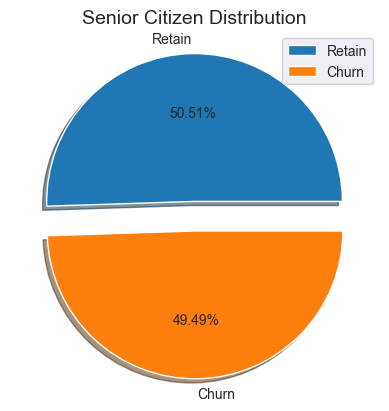

In [4]:

balanced_train_data = pd.read_csv('C:/Users/assus\PyCharmProject\Customers_Churn\data/balanced_train.csv')

plt.pie(
    balanced_train_data['churn'].value_counts(),
    labels=['Retain', 'Churn'],
    autopct='%.2f%%',
    shadow=True,
    explode=[0.1, 0.1]
);
plt.title('Senior Citizen Distribution', fontsize=14)
plt.legend();